# Pelabelan Data Menggunakan VADER

## Import module / package

In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
import json
import reprlib
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/anz007/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Insert Data
### Memasukkan data dari proses sebelumnya

In [3]:
df = pd.read_csv('data/tweets_clean.csv')

## Detokenizing
### Membuat kata - kata yang telah tertoken menjadi kalimat biasa

In [4]:
temp_detokenize = []

def detokenize(text):
    text1 = text.replace(']','').replace('[','')
    arr = text1.replace('"','').replace("\'","").split(",")
    return(TreebankWordDetokenizer().detokenize(arr))

df['tweet'] = df['tweet'].astype('U').apply(detokenize)

## Persiapan Library VADER
### Men-declare modul untuk VADER dan mengganti lexicon default menjadi lexicon custom

In [5]:
# Memanfaatkan nltk VADER untuk menggunakan leksikon kustom
sia1A = SentimentIntensityAnalyzer()
sia1B = SentimentIntensityAnalyzer()
sia2 = SentimentIntensityAnalyzer()

# membersihkan leksikon VADER default
sia1A.lexicon.clear()
sia1B.lexicon.clear()
sia2.lexicon.clear()

# Membaca leksikon InSet
# Leksikon InSet lexicon dibagi menjadi dua, yakni polaritas negatif dan polaritas positif;
# kita akan menggunakan nilai compound saja untuk memberi label pada suatu kalimat
with open('data/lexicon/InSet/positive.json') as f:
    data1A = f.read()
with open('data/lexicon/InSet/negative.json') as f:
    data1B = f.read()

# Membaca leksikon kata2 kasar
with open('data/lexicon/swear-words.json') as f:
    data2 = f.read()

# Mengubah leksikon sebagai dictionary
insetNeg = json.loads(data1A)
insetPos = json.loads(data1B)
senti = json.loads(data2)

# Update leksikon VADER yang sudah 'dimodifikasi'
sia1A.lexicon.update(insetNeg)
sia1B.lexicon.update(insetPos)
sia2.lexicon.update(senti)

print(reprlib.repr(sia1A.lexicon))
print(reprlib.repr(sia1B.lexicon))
print(reprlib.repr(sia2.lexicon))

{'(hujan) gerimis': 1, '(warna) dadu': 3, 'Ahad': 3, 'Sri paduka': 4, ...}
{'(barang) bekas': -4, '(olahraga) bokser': -5, '(tua) uzur': -3, 'Anda': -4, ...}
{'anjay': -5, 'anjiang': -5, 'anjing': -5, 'anjir': -5, ...}


In [6]:
# sample = "kalau kamu sudah sampai sini kamu hebat ayo terus kamu pasti bisa"
# print("insetNeg: ", sia1A.polarity_scores(sample))
# print("insetPos: ", sia1B.polarity_scores(sample))
# print("insetCpdSum: 'compound':", sia1A.polarity_scores(sample)["compound"] + sia1B.polarity_scores(sample)["compound"])

# print("senti\t: ", sia2.polarity_scores(sample))

## Polarity Scoring
### Menilai polaritas yang terdapat pada kata

In [7]:
def polarity(tweet):
    sia1a_pol = sia1A.polarity_scores(tweet)["compound"]
    sia1b_pol = sia1B.polarity_scores(tweet)["compound"]
    sia2_pol = sia2.polarity_scores(tweet)["compound"]
    return sia1a_pol + sia1b_pol 

## Labelling
### Melabelkan kalimat / tweet bedasarkan polaritasnya

In [8]:
df2 = pd.DataFrame()
temp_df2 = []

df2['tweet'] = df['tweet'].copy()

for tweet in df2['tweet']:
    if polarity(tweet) > 0:
        label = "Positif"
    elif polarity(tweet) == 0:
        label = "Netral"
    else:
        label = "Negatif"
    temp_df2.append([label])
    
temp_df2 = pd.DataFrame(temp_df2, columns=['sentimen'])
df2['sentimen'] = temp_df2['sentimen'].copy()
df2.reset_index(drop=True, inplace=True)
df2

tweet sentimen
0      menangani  kekerasan  seksual  disahkan  enam ...  Positif
1      menangani  kekerasan  seksual  disahkan  enam ...  Positif
2         wakil  mpr  ri  mahasiswa  kawal  implementasi  Negatif
3        fadel  muhammad  mahasiswa  kawal  implementasi  Negatif
4                       tanggal  chatnya  april  dijerat  Negatif
...                                                  ...      ...
15627  koordinator  forum  perempuan  indonesia  berd...  Positif
15628          dinilai  penuhi  harapan  kaum  perempuan   Netral
15629  keberadaan  payung  hukum  merehabilitasi  pel...   Netral
15630  menyebut  kehadiran  wujud  keberpihakan  nega...  Positif
15631  ri  rancangan  undang undang  tindak  pidana  ...  Positif

[15632 rows x 2 columns]

## Visualization

### Total tweet positif, negatif, atau netral

In [9]:
print("Positif :",len(df2[df2.sentimen=="Positif"]), " tweet")
print("Netral :",len(df2[df2.sentimen=="Netral"]), " tweet")
print("Negatif :",len(df2[df2.sentimen=="Negatif"]), " tweet")

Positif : 10385  tweet
Netral : 1973  tweet
Negatif : 3274  tweet


In [10]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
#      with open('data/daftar_kata.txt', 'w') as f:
#         print(df2['tweet'].str.split(expand=True).stack().value_counts(), file=f)

### Pie chart dari data labelling

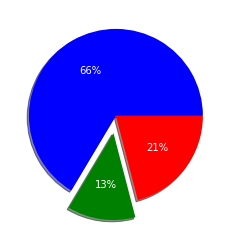

In [11]:
y = np.array([len(df2[df2.sentimen=="Positif"]),  len(df2[df2.sentimen=="Netral"]), len(df2[df2.sentimen=="Negatif"])])
mylabels = ['Positif', 'Netral', 'Negatif']
mycolors = ['blue', 'green', 'red']
myexplode = [0, 0.2, 0]

plt.rcParams['text.color'] = 'white'
plt.pie(y, colors=mycolors, labels = mylabels, explode = myexplode, shadow=True, autopct='%1.0f%%')
plt.show()

### Wordcloud semua data, positif, netral, dan negatif

In [12]:
mask = np.array(Image.open("data/cloud.png"))

def plot_cloud(title, text):
    wc = WordCloud(scale=3,max_words=100,font_path="data/font/GothamMedium.ttf",background_color='white',
                   mask=mask,contour_color='black',contour_width=1).generate(str(" ".join(text)))
    # Set figure size
    plt.figure(figsize=(40,30))
    # Insert image wordcloud
    plt.imshow(wc) 
    # No axis details
    plt.axis("off")
    # Add Title
    plt.title(title)
    # Display image
    plt.show()

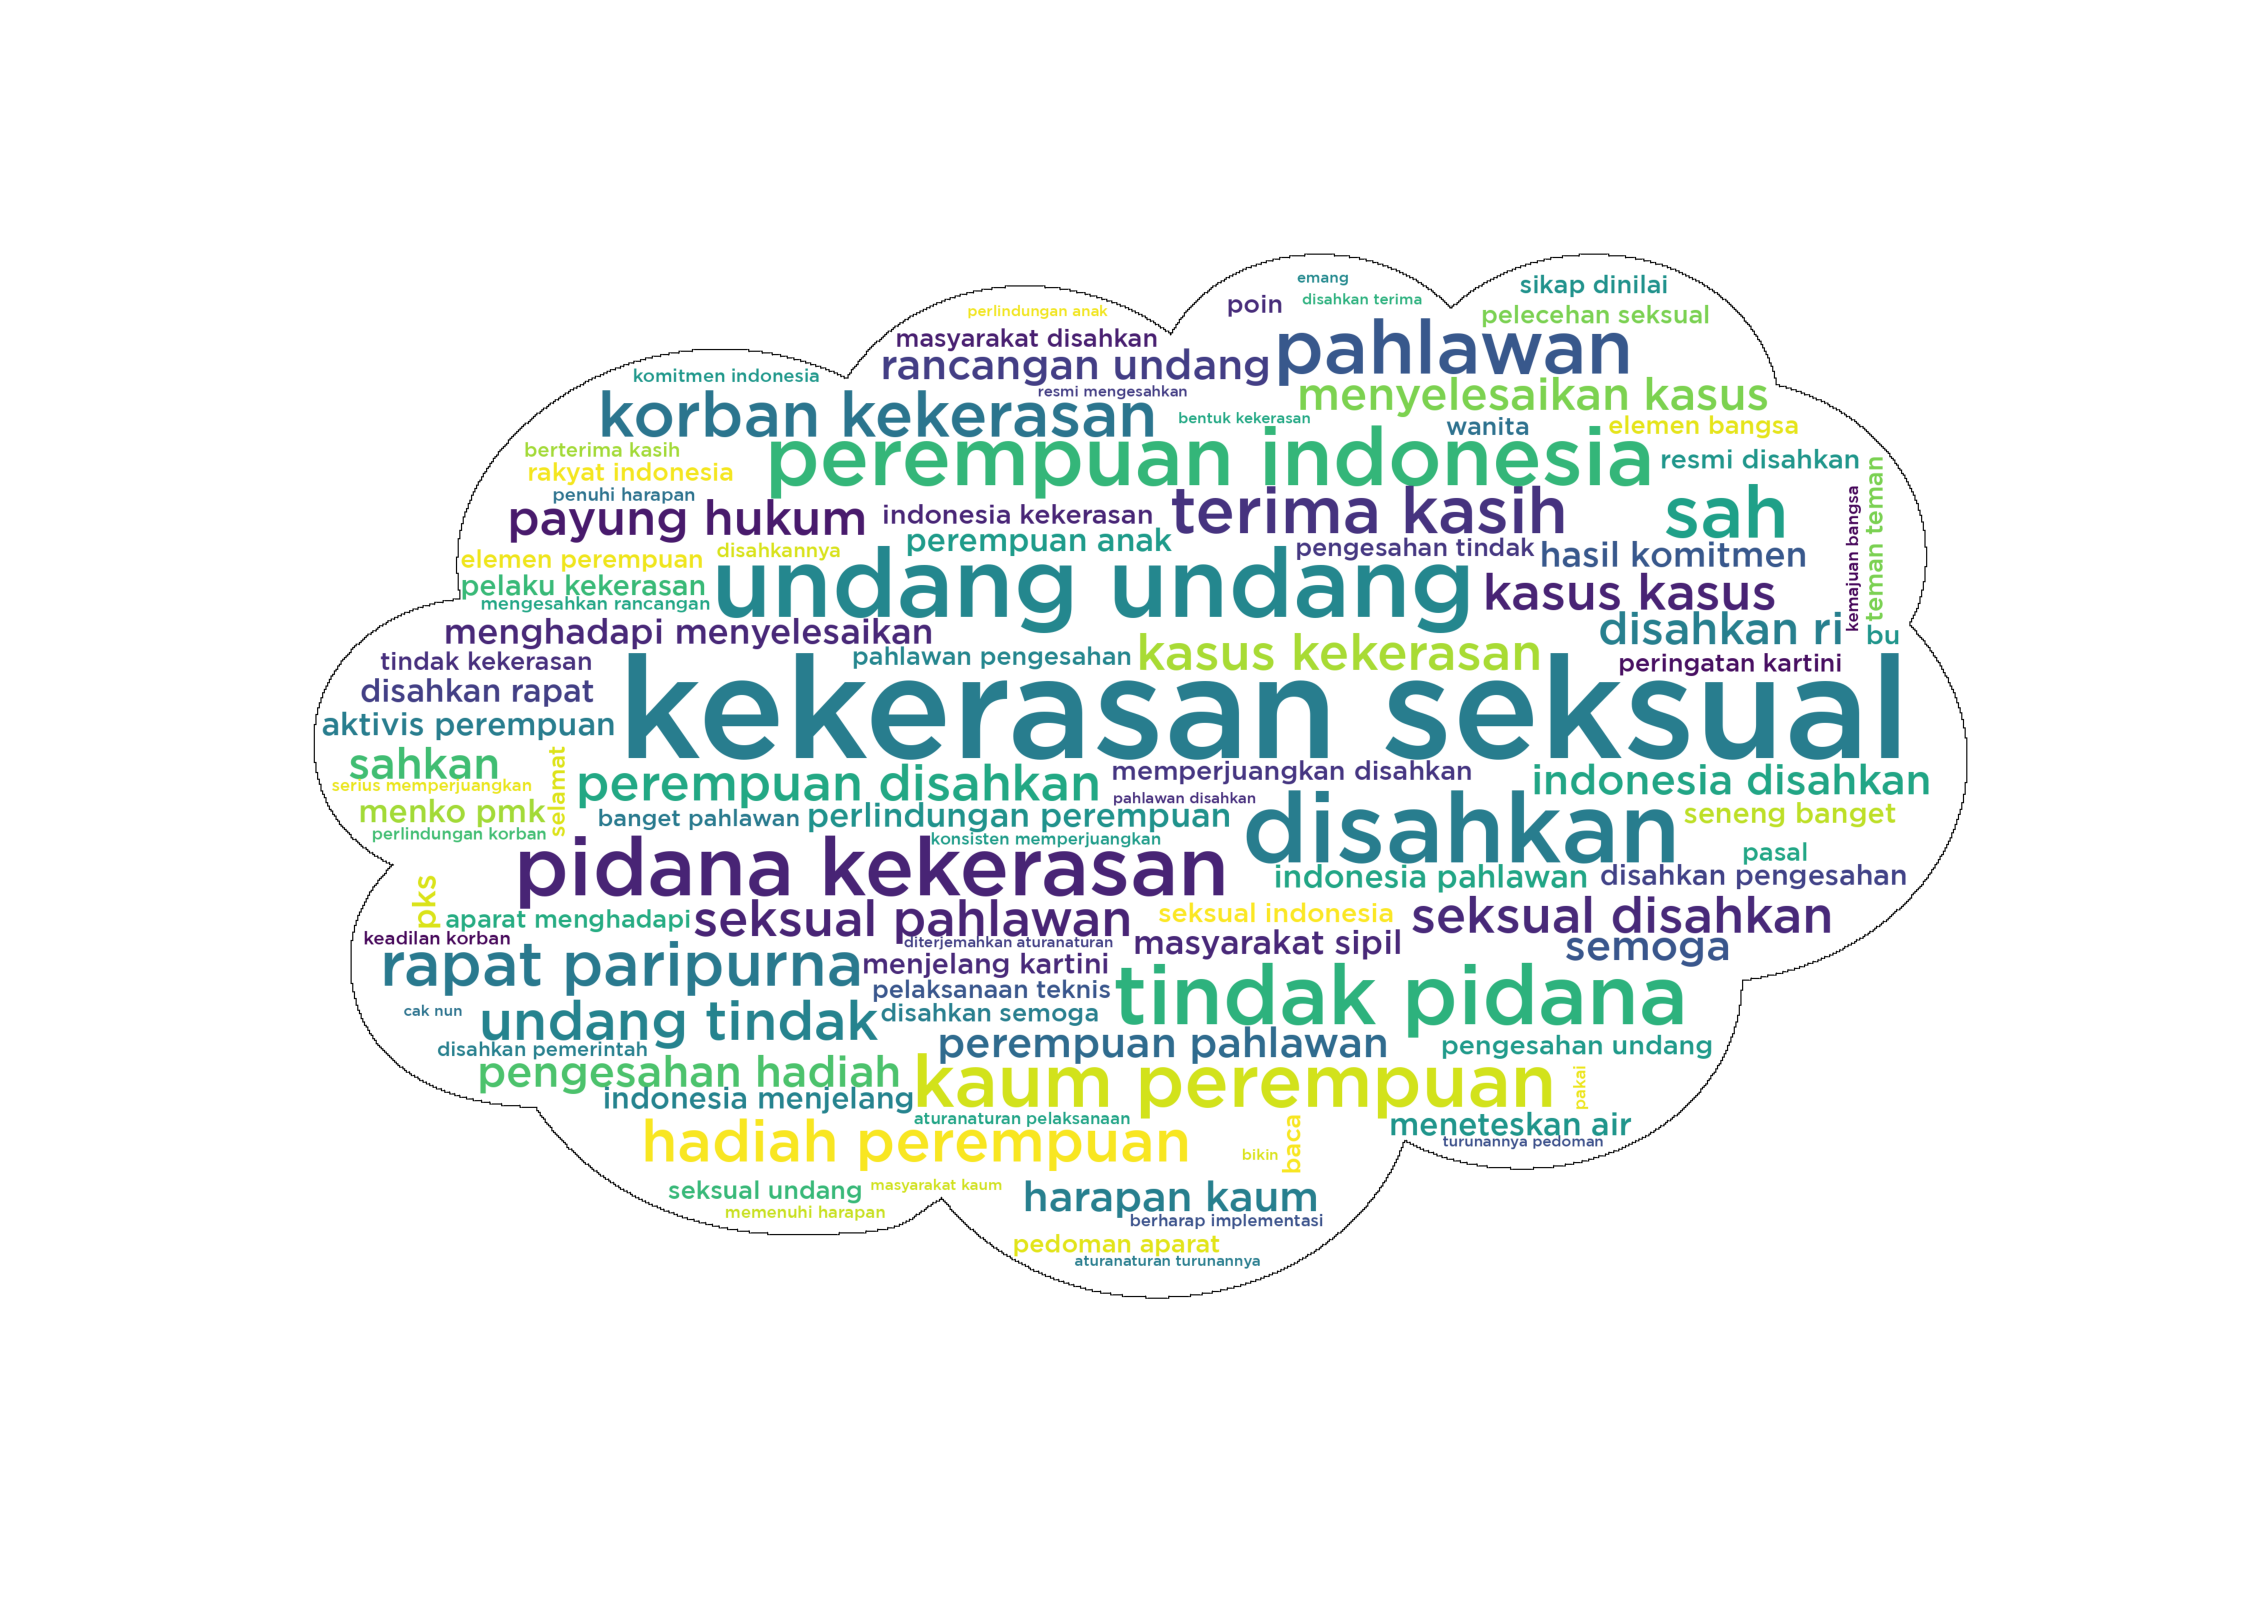

In [13]:
text = df2['tweet'].astype('U')

plot_cloud("Semua Data", text)

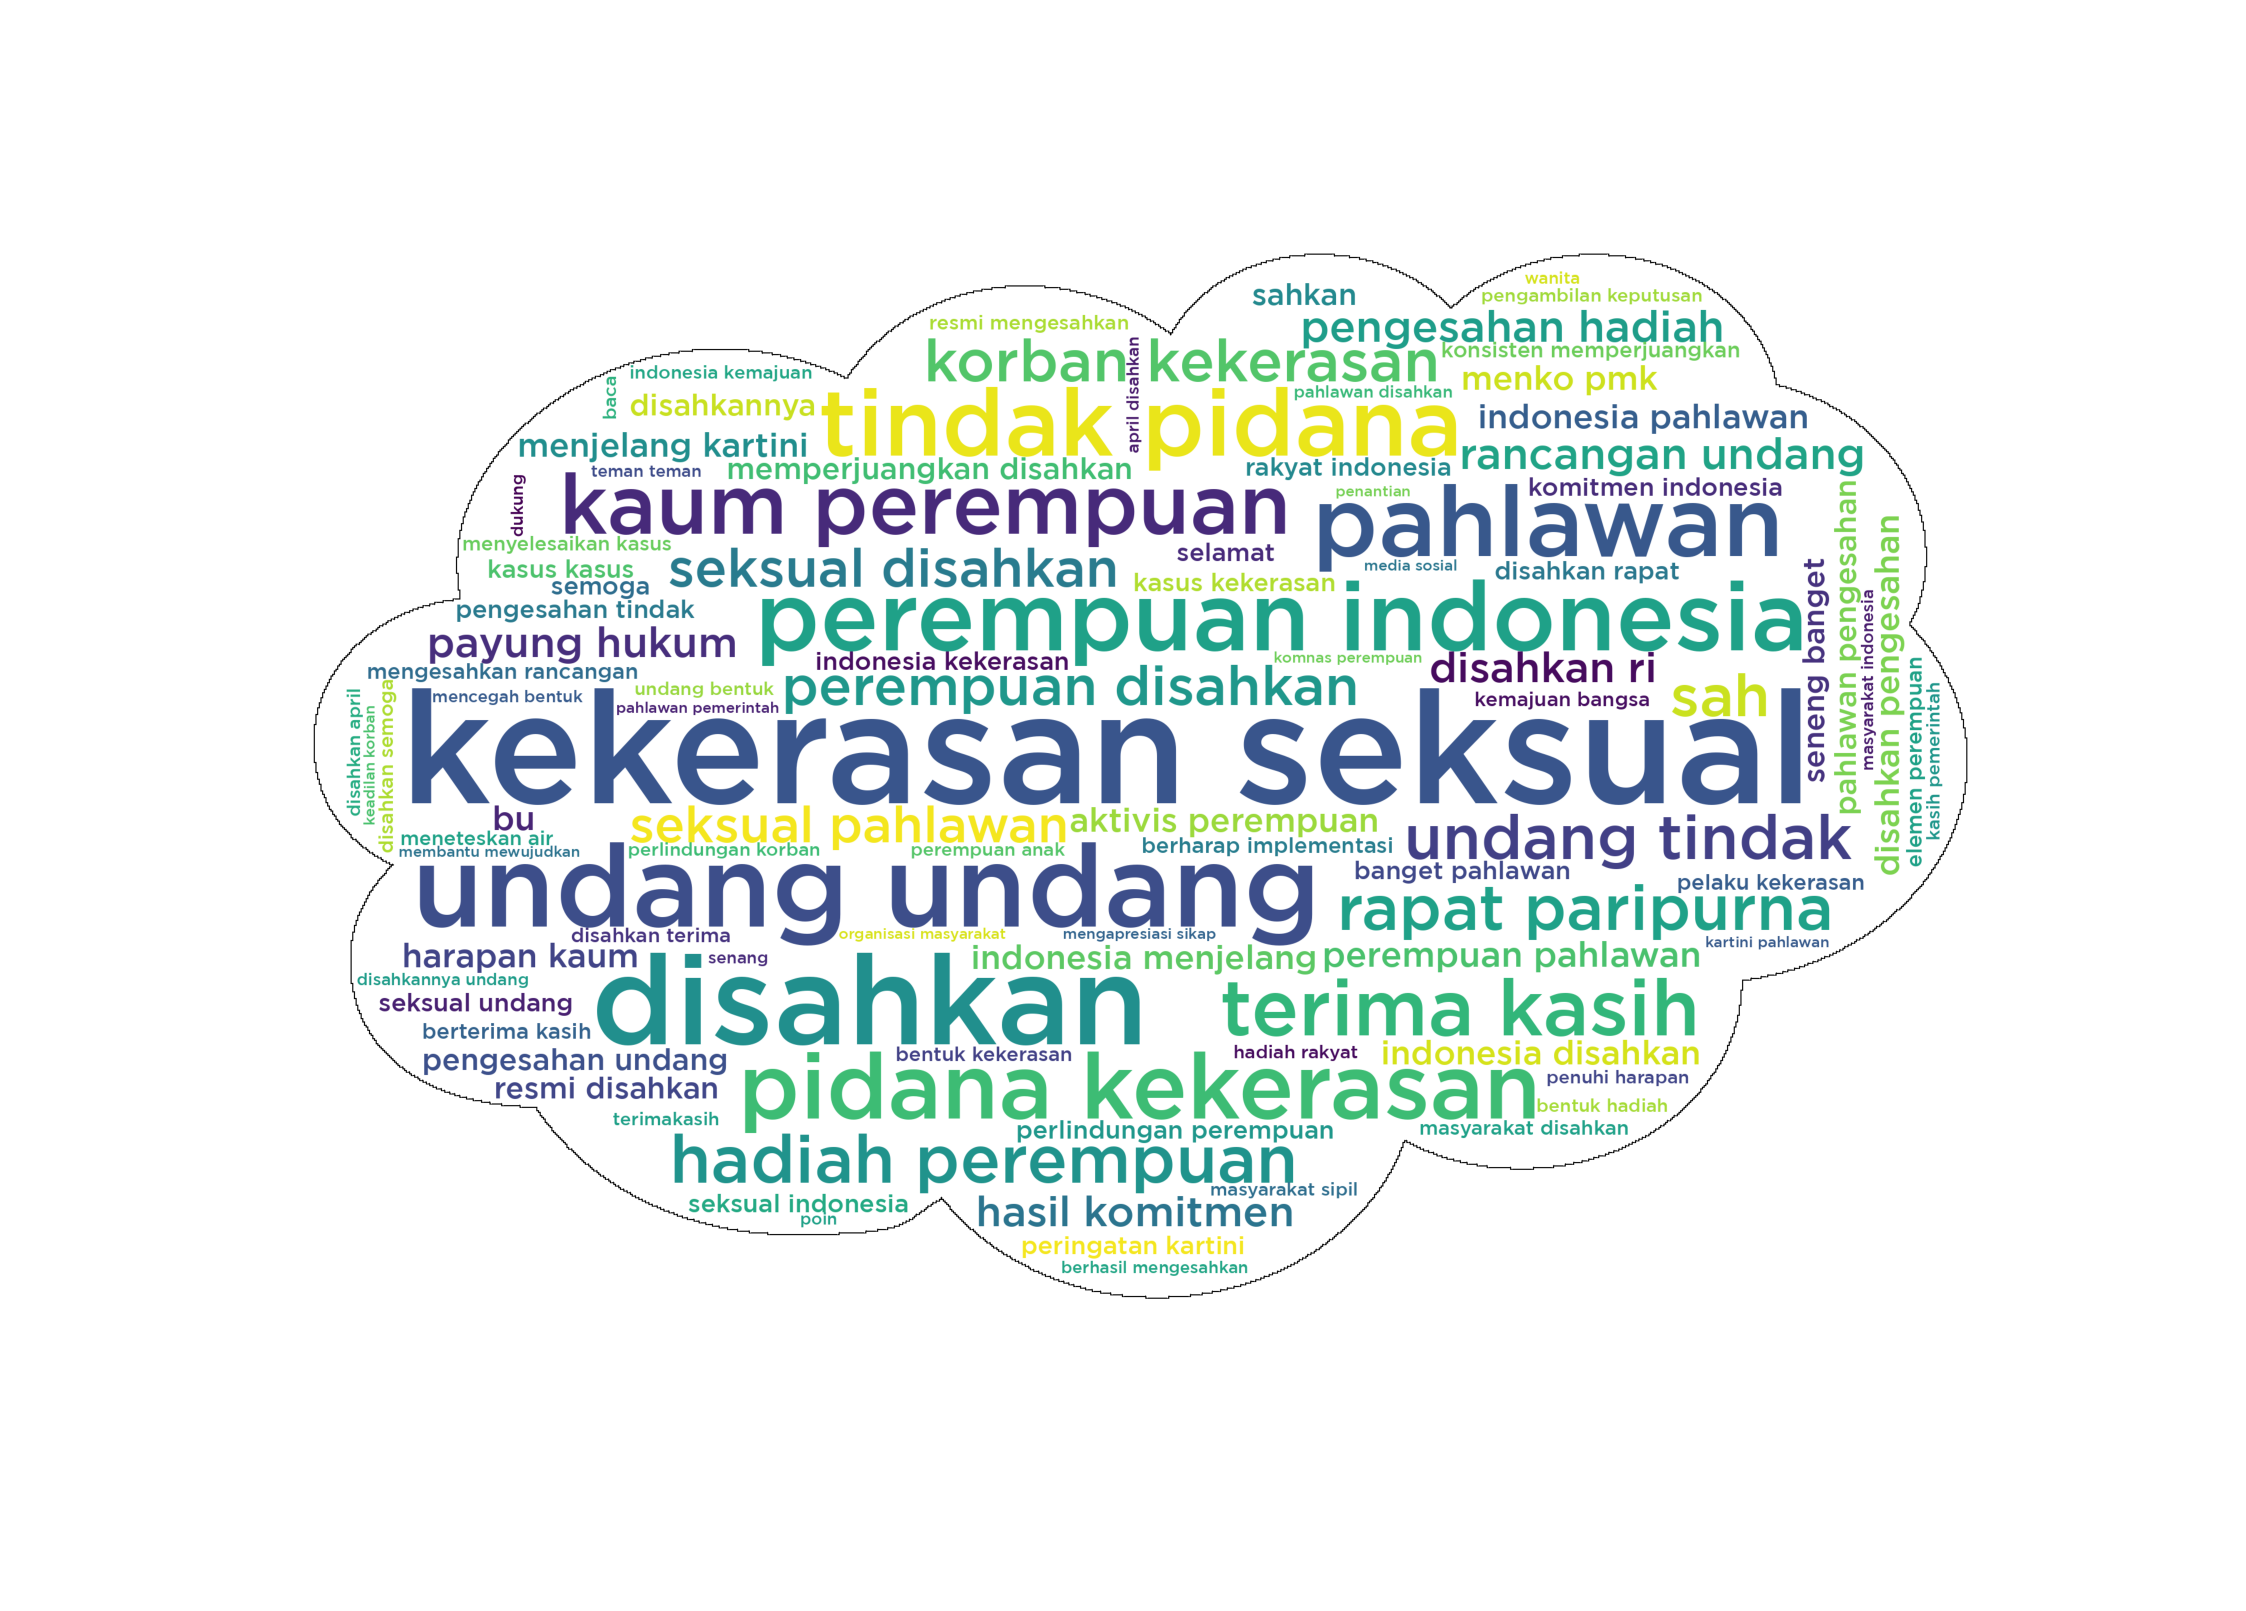

In [14]:
text_pos = df2[df2.sentimen=="Positif"].tweet.astype('U')

plot_cloud("Data Positif", text_pos)

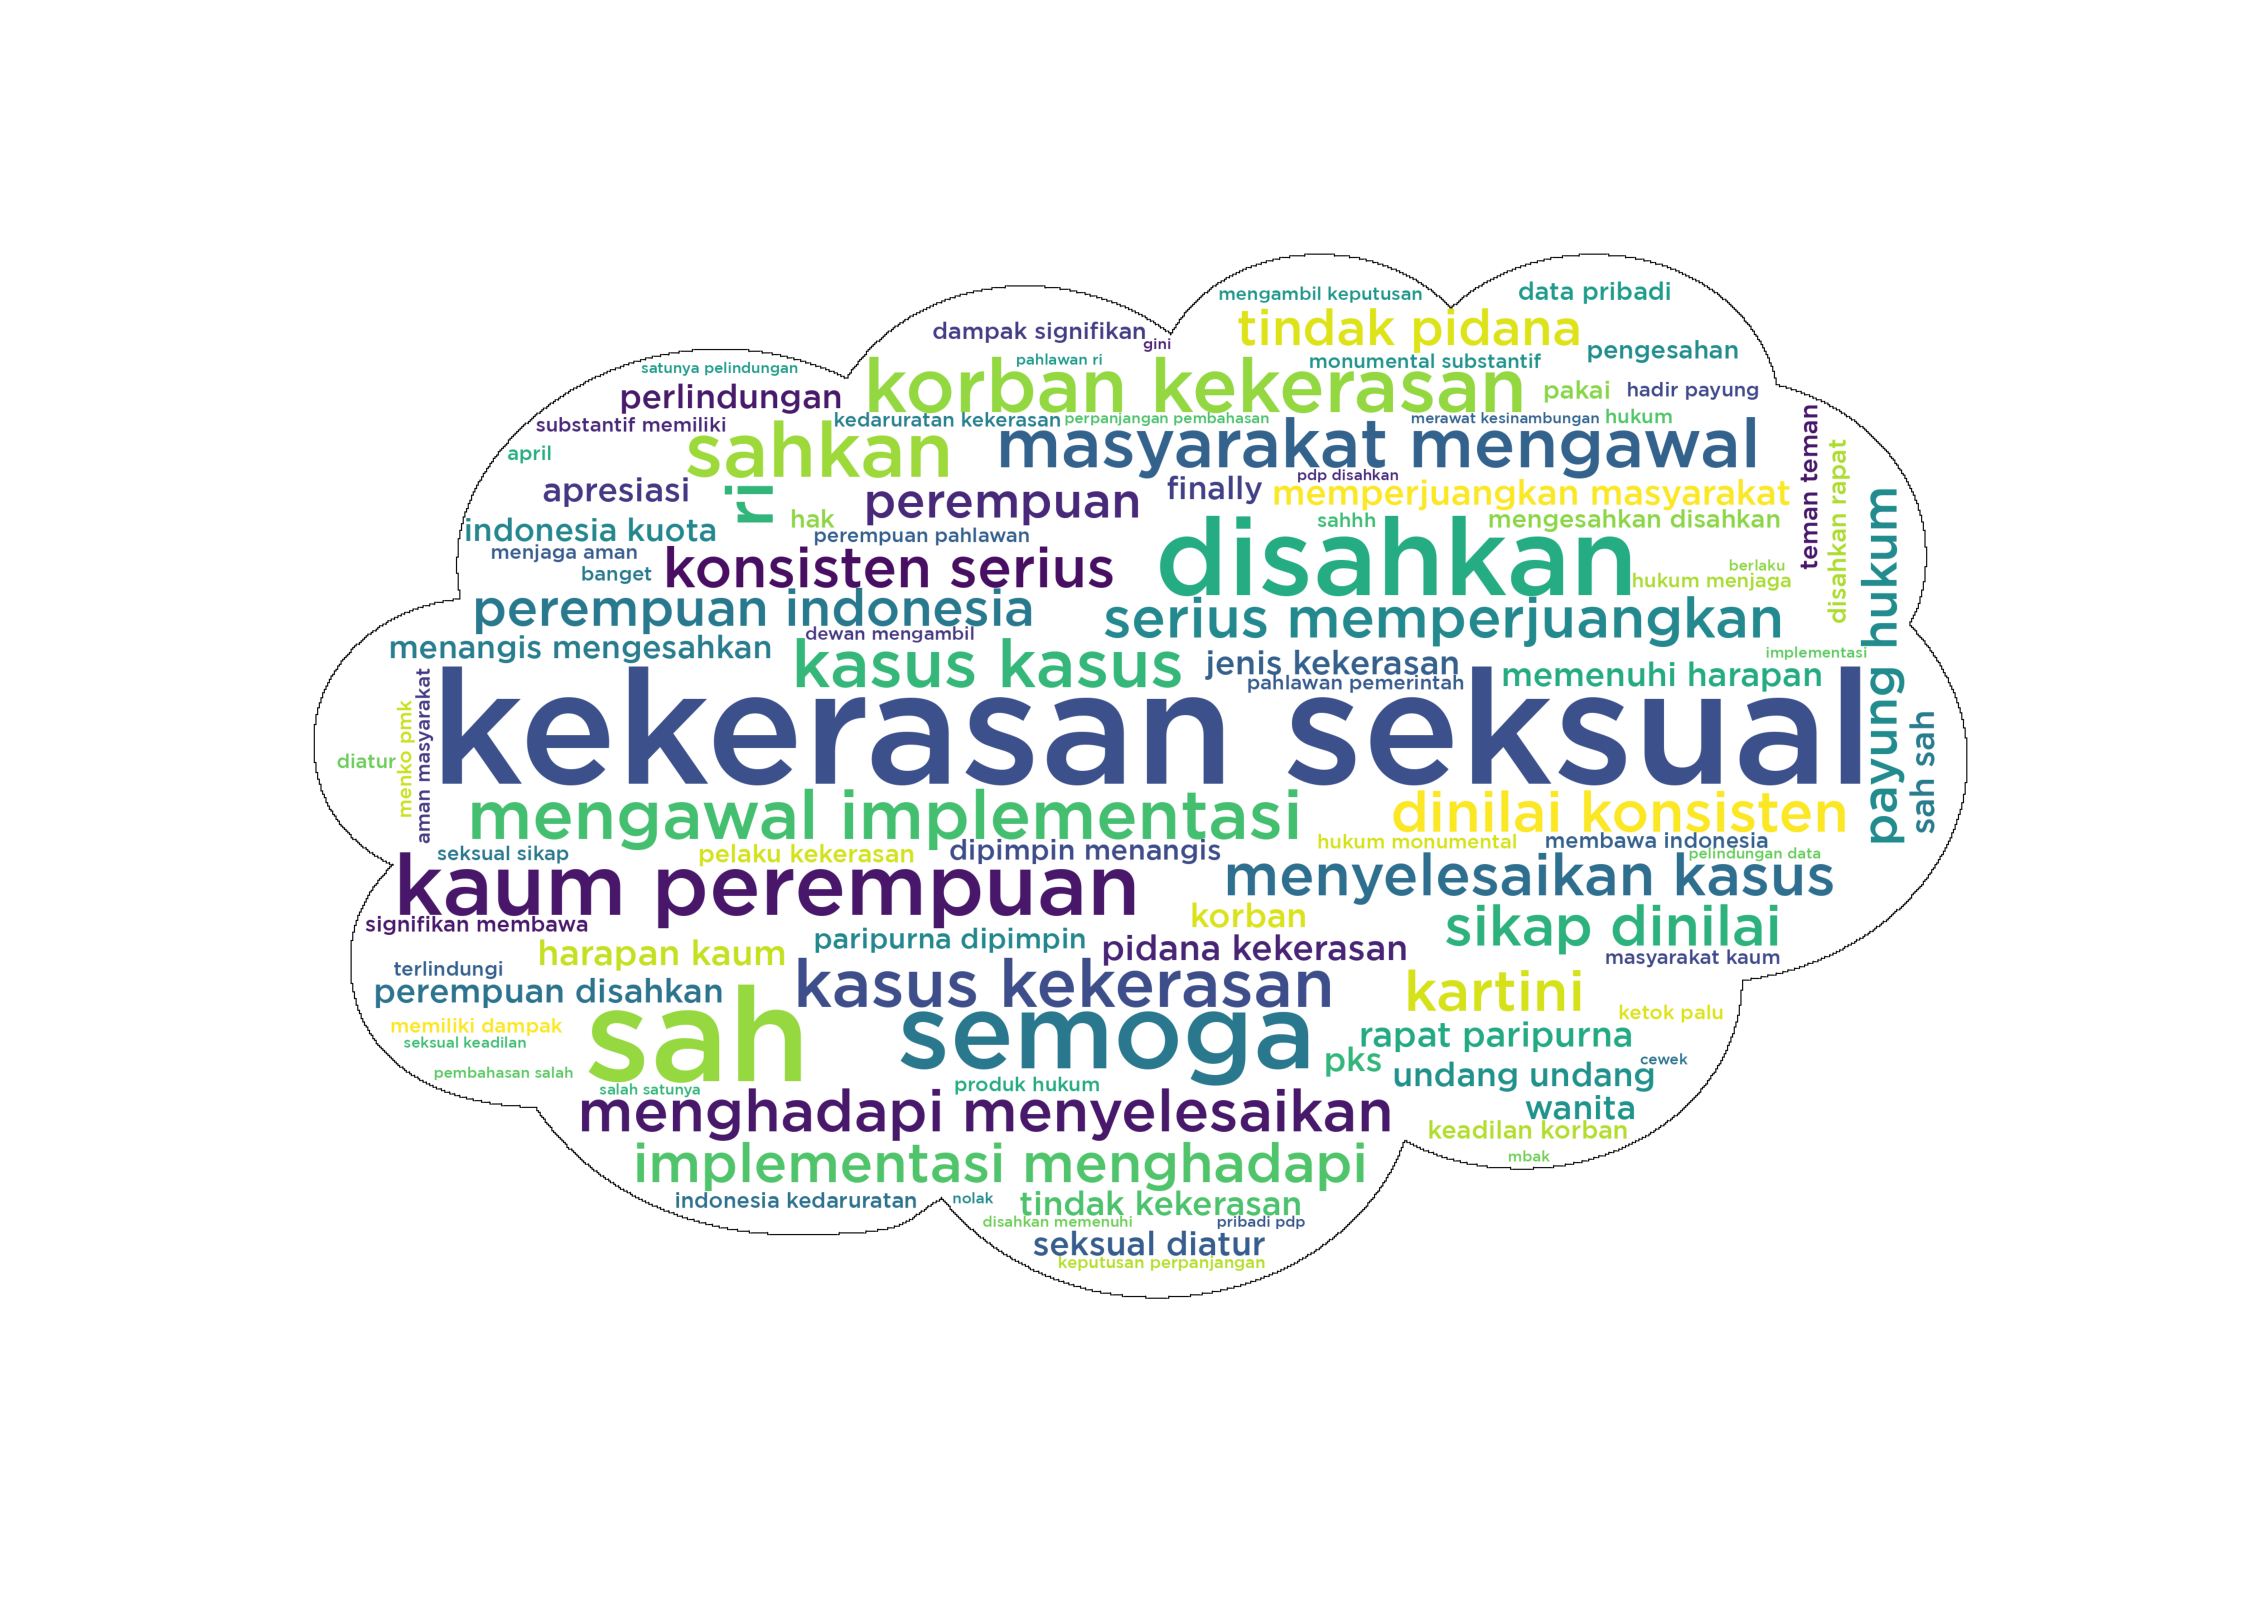

In [15]:
text_net = df2[df2.sentimen=="Netral"].tweet.astype('U')

plot_cloud("Data Netral", text_net)

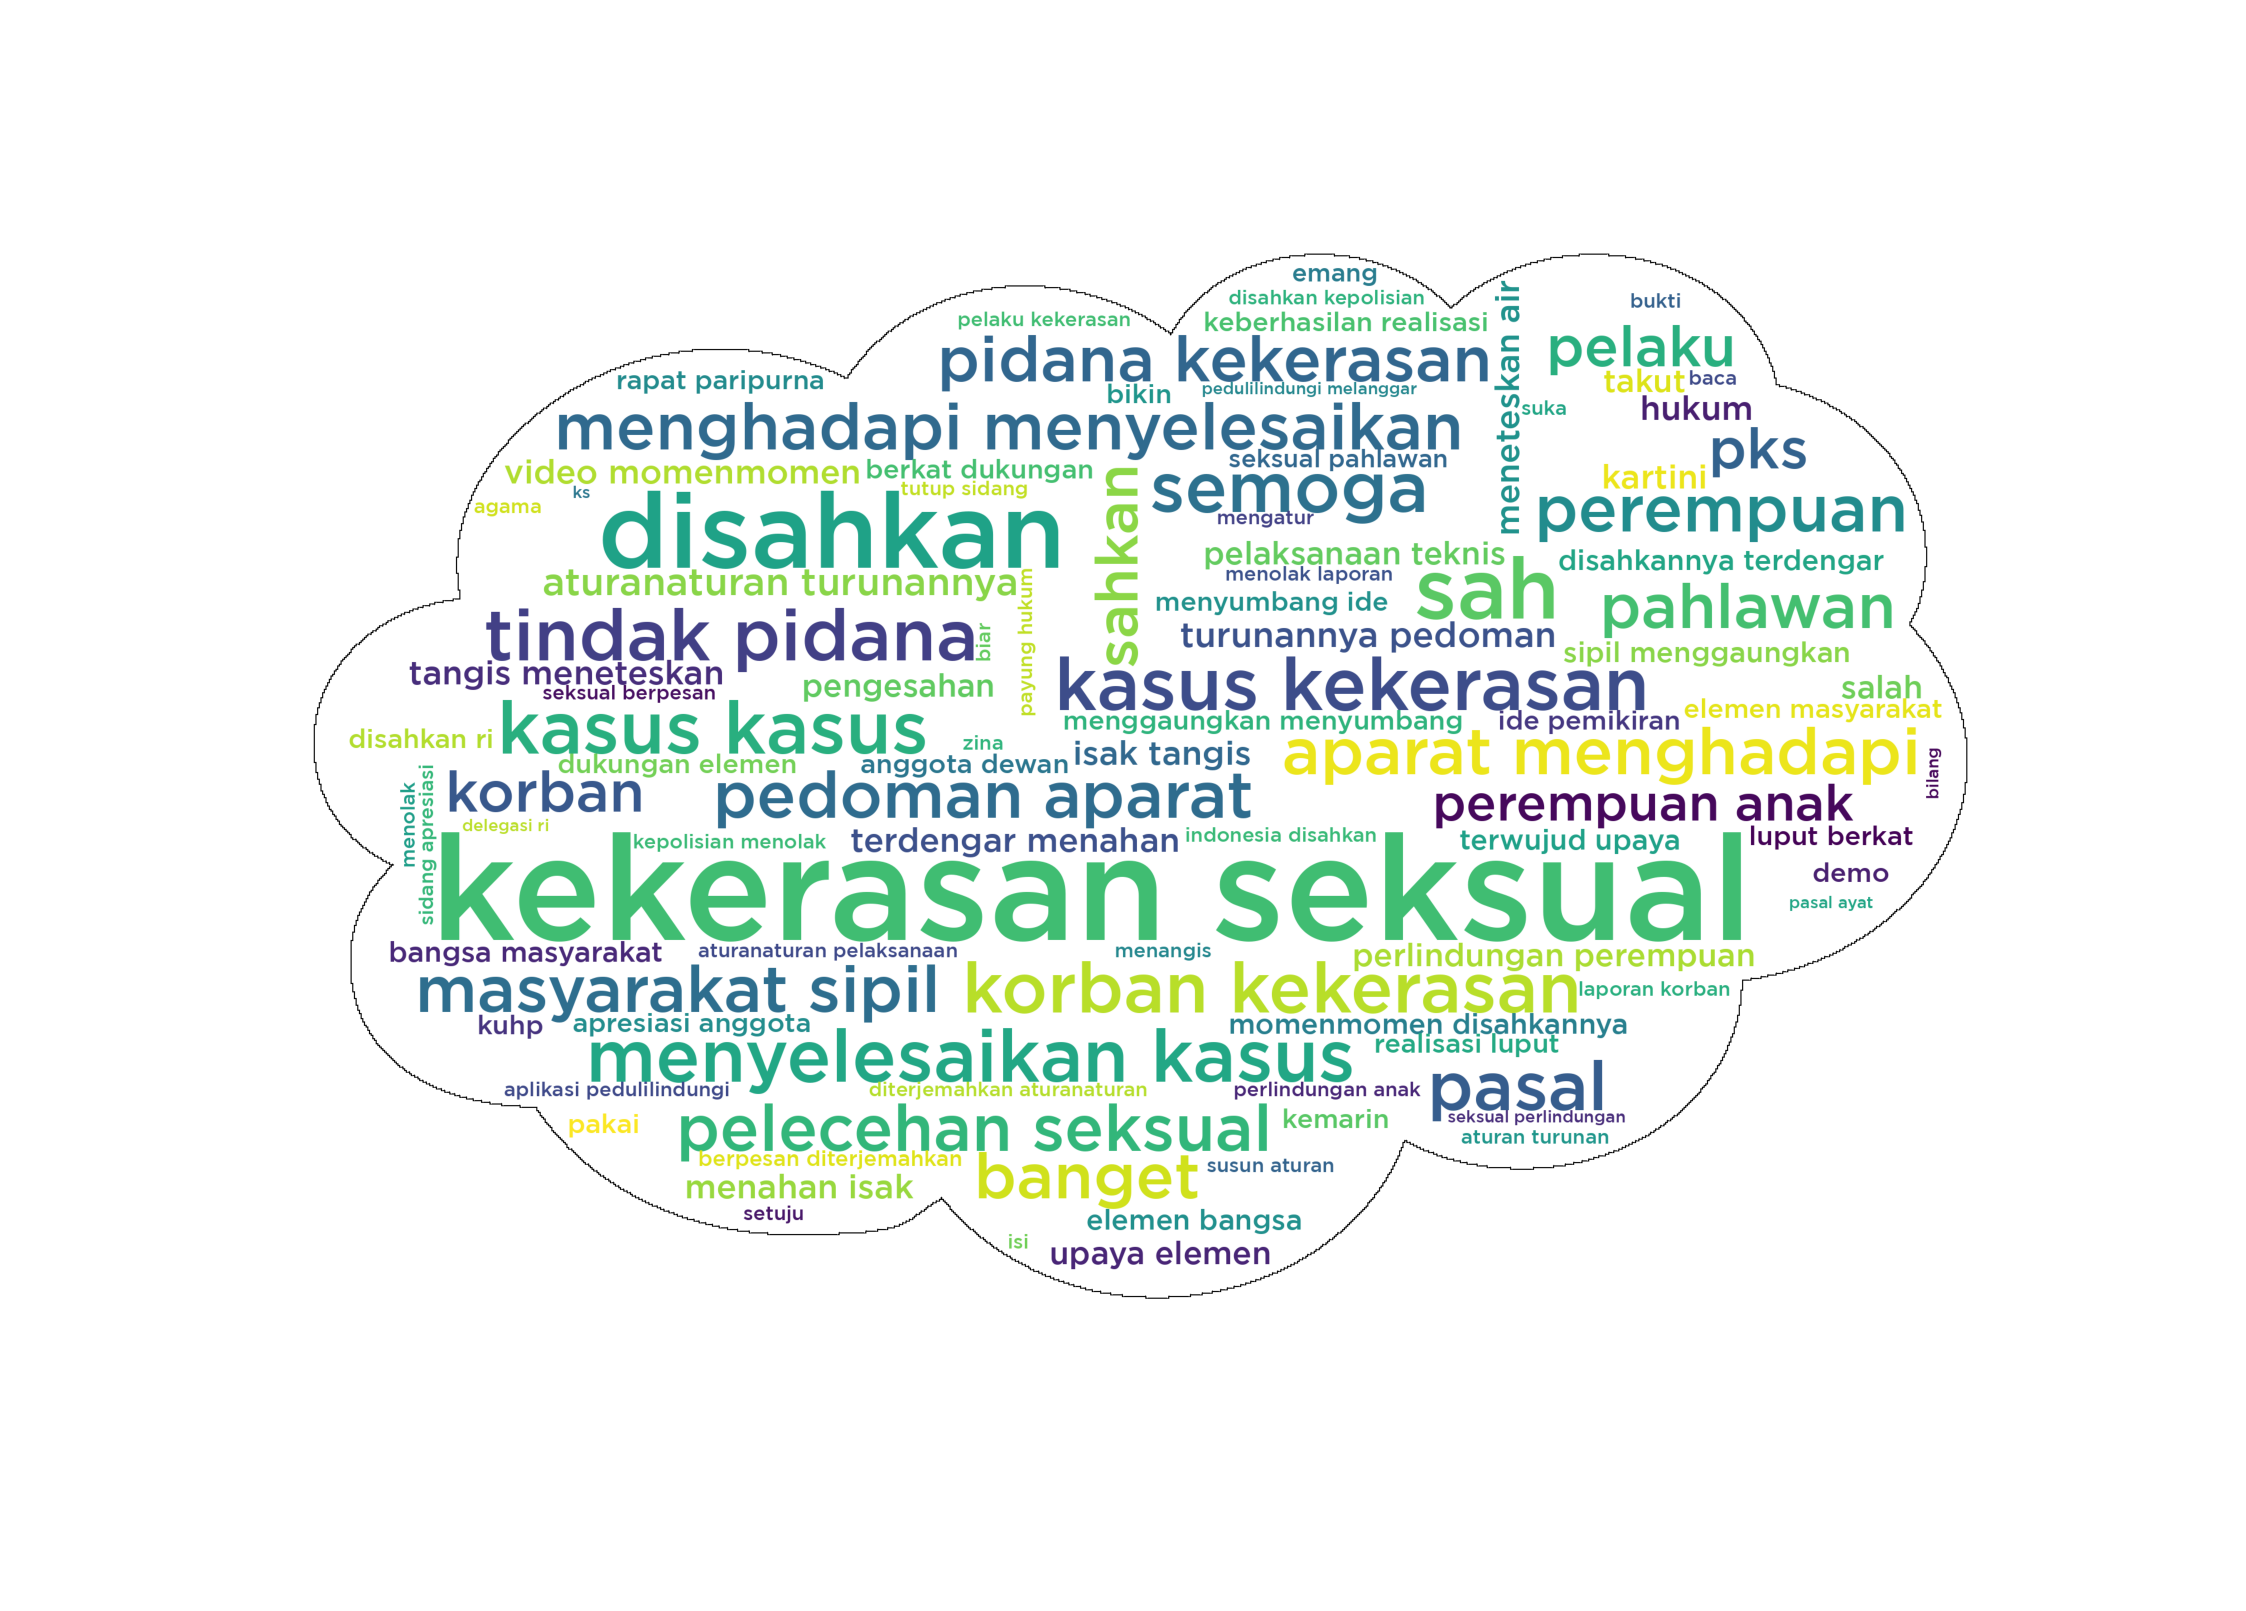

In [16]:
text_neg = df2[df2.sentimen=="Negatif"].tweet.astype('U')

plot_cloud("Data Negatif", text_neg)

## Export data

### Ekspor data per kata positif, negatif, atau netral

In [17]:
df2_positif = df2[df2.sentimen=="Positif"]
df2_netral = df2[df2.sentimen=="Netral"]
df2_negatif = df2[df2.sentimen=="Negatif"]

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
    with open('data/daftar_kata_all.txt', 'w') as f:
        print(df2['tweet'].str.split(expand=True).stack().value_counts(), file=f)
    with open('data/daftar_kata_positif.txt', 'w') as f:
        print(df2_positif['tweet'].str.split(expand=True).stack().value_counts(), file=f)
    with open('data/daftar_kata_netral.txt', 'w') as f:
        print(df2_netral['tweet'].str.split(expand=True).stack().value_counts(), file=f)
    with open('data/temp/daftar_kata_negatif.txt', 'w') as f:
        print(df2_negatif['tweet'].str.split(expand=True).stack().value_counts(), file=f)

### Ekspor data labelling untokenized

In [18]:
df2.to_csv("data/tweets_labelled_nltk.csv", index=False)

### Ekspor data labelling tokenized

In [19]:
nltk.download('punkt')
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df2['tweet'] = df2['tweet'].apply(word_tokenize_wrapper)
df2.to_csv("data/tweets_labelled_tokenized_nltk.csv", index=False)

[nltk_data] Downloading package punkt to /home/anz007/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
